In [1]:
from IPython.display import Image, display
import pandas as pd
import json
from functools import lru_cache
from dotenv import load_dotenv
import time
import yfinance as yf

from fuzzywuzzy import process

from langchain_openai import ChatOpenAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage
from langchain_core.messages import RemoveMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.graph.message import REMOVE_ALL_MESSAGES
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

from typing import TypedDict, Literal, Optional, Dict, Union
from typing_extensions import Annotated
from operator import add

In [2]:
# Load env variables from .env.example
load_dotenv("../.env")

True

In [3]:
# Constants
FUZZY_LIMIT = 5
LOW_CONFIDENCE_THRESHOLD = 50  # Minimum score to consider
HIGH_CONFIDENCE_THRESHOLD = 90  # If score ≥ 90, skip LLM

In [4]:
# initialize model for large number of input tokens
llmg = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [5]:
# Load CSV of NSE companies
df = pd.read_csv("../data/EQUITY_L.csv")  # Assumes columns: "Company Name", "Symbol"
company_names = df["NAME OF COMPANY"].tolist()

In [6]:
# Prompt to extract company name
prompt_extract_symbol = ChatPromptTemplate.from_template(
    "Extract only the company or stock name from the user's stock-related messages. "
    "Respond with the extracted company name as a single string. "
    "messages: {messages}"
)
# Prompt to answer user messages
prompt_answer_messages_wo_news = ChatPromptTemplate.from_template(
    "You are a helpful financial expert who can provide answers to user queries.\n\n"
    "You are provided with structured stock-related data for a company: {stock_info}\n\n"
    "The user has asked: {messages}\n\n"
    "Your task:\n"
    "- If the messages can be answered using ONLY the provided data, give a clear, concise response (max 350 words).\n"
    "- If the data is insufficient to fully answer the messages, state clearly that the available information is not enough.\n\n"
    "Do not use any external knowledge or assumptions. Base your answer strictly on the given data."
)

prompt_answer_messages = ChatPromptTemplate.from_template(
    "You are a helpful financial expert who can provide answers to user queries (max 450 words).\n\n"
    "You are provided with two sources of information:\n"
    "- Structured stock-related data: {stock_info}\n"
    "- Recent news summaries (if any): {news_data}\n\n"
    "The user has asked: {messages}\n\n"
    "Your task:\n"
    "- Use the structured data as the primary source for factual, numeric, and financial information.\n"
    "- If news summaries are provided (non-empty), also consider them to enrich the answer. "
    "Clearly mention the insights derived from the news (e.g., 'According to recent news...').\n"
    "- If news_data is empty, ignore it and rely only on stock_info.\n"
    "- If neither stock_info nor news_data contain enough information to fully answer, state clearly that the available information is not enough.\n\n"
    "Constraints:\n"
    "- Keep your answer clear, concise, and under 350 words.\n"
    "- Do not use any external knowledge or assumptions beyond the provided stock_info and news_data."
)

prompt_route_all = ChatPromptTemplate.from_template(
    "You are a classifier for a stock analysis app.\n"
    "You will be given a list of messages. Consider the last message in the context of previous ones and classify it.\n\n"
    "Return only one of the following labels:\n"
    "1. 'new' — The last message is about exactly one specific stock and explicitly names it.\n"
    "2. 'follow_up' — The last message refers to a stock discussed earlier without naming it, or uses terms like 'it', 'that stock', 'the same', 'reset session'.\n"
    "3. 'other' — The last message is a greeting, unrelated to stocks, mentions more than one stock, or is about general stock market trends.\n\n"
    "Do not generate explanations or any additional text. Respond with exactly one label.\n\n"
    "Messages: {messages}"
)

prompt_handle_other = ChatPromptTemplate.from_template(
    "You are a polite assistant for a stock analysis app.\n"
    "You will be given the last user message.\n\n"
    "Rules:\n"
    "1. If it is a simple greeting (hello, hi, good morning, how are you, etc.):\n"
    "   - Greet back warmly.\n"
    "   - Mention that this app can help analyze a single stock for short-term or long-term insights.\n"
    "2. For any other message:\n"
    "   - Politely explain that this app can only help with single stock analysis and cannot answer other types of questions.\n\n"
    "Message: {message}"
)
prompt_news_relevance = ChatPromptTemplate.from_template(
    "Decide if stock news is relevant for answering the last query in the list. "
    "Rules: "
    "- Relevant → The last query is about investment decisions, future outlook, stability, risks, or long-term prospects (e.g., 'Should I invest?', 'Is it good for long term?', 'Does the company look stable?'). "
    "- Irrelevant → The last query only asks for numeric/financial metrics (e.g., price, P/E ratio, market cap, book value), which can be answered from structured data without news. "
    "Respond with one word only: 'relevant' or 'irrelevant'. "
    "Messages: {messages} "
)

In [7]:
class GraphState(MessagesState):
    non_stock: bool = False            # True if query is not stock related
    follow_up: Optional[bool] = False   # None until determined; then True/False
    symbol: Optional[str] = None       # Stock symbol, e.g., 'HDFCBANK'
    stock_info: Optional[Dict] = None  # Populated after fetching stock data
    news_required: bool = False
    news_data: Optional[str] = None
    response: Optional[str] = None     # Model's textual reply

In [8]:
def classify_query(state: GraphState) -> dict:
    chain = prompt_route_all | llmg
    result = chain.invoke({"messages": state["messages"]}).content.strip()

    if result == "follow_up":
        return {"follow_up": True, "non_stock": False}

    elif result == "new":
        if len(state["messages"]) > 1:
            # keep only the latest message
            return {
                "follow_up": False,
                "non_stock": False,
                "news_required": False,
                "news_data": "",
                "stock_info": None,
                "messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
            }
        return {"follow_up": False, "non_stock": False}

    else:  # "other"
        return {
            "non_stock": True,
            "follow_up": False,
            "messages": [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
        }

In [9]:
def news_required(state: GraphState) -> dict:
    chain = prompt_news_relevance | llmg
    result = chain.invoke({"messages": state["messages"]}).content.strip()
    if result == "relevant":
        return {"news_required": True}
    else:
        return {"news_required": False}

In [10]:
# Node to extract company symbol for single stock queries
def extract_symbol(state: GraphState) -> GraphState:
    symbol = "NO_MATCH"
    chain = prompt_extract_symbol | llm
    extracted_name = chain.invoke({"messages": state["messages"]}).content.strip()
    # Fuzzy matching
    matches = process.extract(extracted_name, company_names, limit=FUZZY_LIMIT)
    best_match, best_score = matches[0]
    # High-confidence match
    if best_score >= HIGH_CONFIDENCE_THRESHOLD:
        symbol = df[df["NAME OF COMPANY"] == best_match]["SYMBOL"].values[0]
    
    return {"symbol": symbol}

In [11]:
# Cache important keys CSV so it’s loaded only once
@lru_cache(maxsize=1)
def load_keys_to_keep(csv_path="../important_keys.csv"):
    try:
        keys_df = pd.read_csv(csv_path, header=None)
        return set(keys_df.iloc[0].dropna().tolist())
    except Exception:
        return set()

In [12]:
# # node to get news data
def get_stock_news_info(stock) -> str:
    news_string = ""    
    try:
        news = stock.get_news(count=3)
        for article in news:
            news_string += f"Publication Date: {article['content']['pubDate'][:10]}\nsummary:  {article['content']['summary']}\n"
    except Exception as e:
        print(f"error getting news: {e}")
    return news_string

In [13]:
def get_stock_info(state: GraphState) -> GraphState:
    """
    Fetch stock information and optionally recent news for the given symbol.
    Returns a dictionary with 'stock_info' and 'news_data'.
    """

    # Handle missing/invalid symbol
    if state.get("symbol") == "NO_MATCH":
        return {"stock_info": {"data": "No data available"}, "news_data": []}

    stock_symbol = state["symbol"]
    try:
        stock = yf.Ticker(f"{stock_symbol}.NS")
    except Exception:
        return {"stock_info": {"data": "No data available"}, "news_data": []}

    result = {"news_data": state.get("news_data", [])}

    # Handle follow-up queries
    if state.get("follow_up", False):
        if state.get("news_required", False) and not result["news_data"]:
            result["news_data"] = get_stock_news_info(stock)
        return result

    # Handle new queries → fetch structured stock info
    try:
        keys_to_keep = load_keys_to_keep()
        info = stock.info
        filtered_info = {k: v for k, v in info.items() if k in keys_to_keep}
        if not filtered_info:
            filtered_info = {"data": "No data available"}
    except Exception:
        filtered_info = {"data": "No data available"}

    result["stock_info"] = filtered_info

    # Fetch news only if required and not already present
    if state.get("news_required", False) and not result["news_data"]:
        result["news_data"] = get_stock_news_info(stock)

    return result

In [14]:
def route_query(state: GraphState) -> Literal["new", "follow_up", "other"]:
    if state.get("non_stock"):
        return "other"
    elif state.get("follow_up"):
        return "follow_up"
    else:
        return "new"

In [15]:
def answer_user_messages(state: GraphState) -> Optional[Union[dict, GraphState]]:
    # Handle "other" type queries (non-stock, greetings, multi-stock)
    if state.get("non_stock", False):
        chain = prompt_handle_other | llmg
        result = chain.invoke({"message": state["messages"][-1]})
        return {"response": result}

    result = None
    formatted_info = json.dumps(state.get("stock_info", {}), indent=2)
    # Handle single-stock queries (follow_up or new)
    if state.get("news_required", False):
        chain = prompt_answer_messages | llmg
        result = chain.invoke({
            "messages": state["messages"][-1],
            "stock_info": formatted_info,
            "news_required": False,
            "news_data": state["news_data"]
        })
    else:
        chain = prompt_answer_messages_wo_news | llmg
        result = chain.invoke({
            "messages": state["messages"][-1],
            "stock_info": formatted_info,
        })    

    return {"response": result}


In [16]:
# Build the graph
workflow = StateGraph(GraphState)

workflow.add_node("extract_symbol", extract_symbol)
workflow.add_node("get_stock_info", get_stock_info)
workflow.add_node("answer_user_messages", answer_user_messages)
workflow.add_node("classify_query", classify_query)
workflow.add_node("news_required", news_required)

workflow.add_edge(START, "classify_query")
workflow.add_conditional_edges(
    "classify_query",
    route_query,
    {
        "new": "extract_symbol",
        "follow_up": "news_required",
        "other": "answer_user_messages"
    }
)
workflow.add_edge("extract_symbol", "news_required")
workflow.add_edge("news_required", "get_stock_info")
workflow.add_edge("get_stock_info", "answer_user_messages")
workflow.add_edge("answer_user_messages", END)

In [17]:
# Configure memory
checkpointer = MemorySaver()
# Compile the graph with checkpointer
app = workflow.compile(checkpointer=checkpointer)

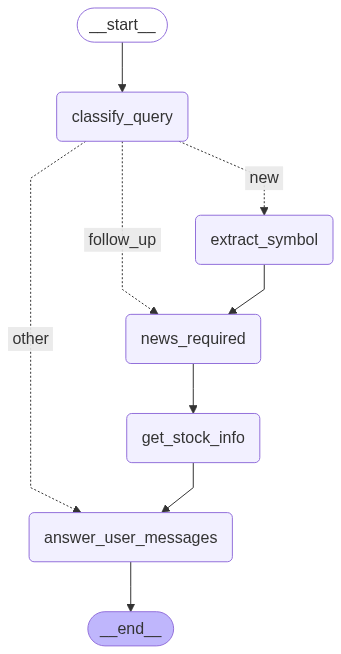

In [18]:
# View
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
# thread_id = "1"  # Unique identifier for user session
# config = {"configurable": {"thread_id": thread_id, "checkpointer": checkpointer}}
# # Test with a single stock messages
# messages = HumanMessage(input())
# result = app.invoke({"messages": messages}, config=config)
# print(result["response"].content)
# # print(result["news_data"])
# # result

In [20]:
config = {"configurable": {"thread_id": "5"}}
node_to_stream = 'answer_user_messages'
input_message = HumanMessage(content=input())
async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="")

 What is the current value of NTPC?


The current value of NTPC is 339.35 INR.


In [21]:
# message = [HumanMessage(content='What is the value of ABB india today?', additional_kwargs={}, response_metadata={}, id='47d48867-a9a4-442b-9d69-21e5629f61e6'),
#            HumanMessage(content='Cool, what is the current P/E?', additional_kwargs={}, response_metadata={}, id='3a7b32f5-371b-45e9-acd6-a6dfbe6ea36c'),
#            HumanMessage(content='How much NTPC is trading for today?', additional_kwargs={}, response_metadata={}, id='92f935b3-a30e-4ee0-bf26-e2e8c3cac810')]

# message = [RemoveMessage(id=m.id) for m in message[:len(message)-1]]
# message

In [22]:
# Start conversation
# input_message = HumanMessage(content="hi!")
# for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
#     for m in event['messages']:
#         m.pretty_print()
#     print("---"*25)

In [23]:
# config = {"configurable": {"thread_id": "3"}}
# input_message = HumanMessage(content=input())
# async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
#     print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

In [24]:
# node_to_stream = 'answer_user_messages'
# config = {"configurable": {"thread_id": "4"}}
# input_message = HumanMessage(content="Hello")
# async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
#     # Get chat model tokens from a particular node 
#     if event["event"] in ["on_chat_model_stream", "on_chain_stream"] and event['metadata'].get('langgraph_node','') == node_to_stream:
#         print(event["data"])

In [25]:
# node_to_stream = 'answer_user_messages'
# config = {"configurable": {"thread_id": "4"}}
# input_message = HumanMessage(content=input())
# async for event in app.astream_events({"messages": [input_message]}, config, version="v2"):
#     # Get chat model tokens from a particular node 
#     if event["event"] in ["on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
#         print(event["data"]["chunk"].content)

In [26]:
# stock_symbol = "HDFCBANK"
# news_string = ""
# stock = yf.Ticker(f"{stock_symbol}.NS")
# news = stock.get_news(count=5)
# for article in news:
#     news_string += f"Publication Date: {article['content']['pubDate'][:10]}\nsummary:  {article['content']['summary']}\n"
# print(news_string)